# Tugas Besar ML Bagian C
---
### Anggota
1. M. Khairul Makirin - 13517088
2. Avisenna Abimanyu - 13517010
3. Muhammad Fariz Lutfan Wakan - 13517034
4. Ihsan Azhar Imaduddin - 13517043



### Spesifikasi
* Fungsi aktivasi : Sigmoid (1/1+e^-y)<br/>
* Perhitungan error : E = 1/2(T - O)^2<br/>
* Fungsi update weight : W' = W + DeltaW
* Fungsi update DeltaW : DeltaW' = DeltaW + learning_rate x delta_node x input_node
* Batch size = 30



In [0]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris_dataset = load_iris()
irisTrainInstances, irisTestInstances, irisTrainTargets, irisTestTargets = train_test_split(iris_dataset.data, iris_dataset.target, test_size=0.1)

### MLP Class

In [0]:
import math
import numpy as np

class MiniBatchGradientMLP:
  def __init__(self, nodesArr, batchSize):
    self.batchSize = batchSize
    self.layers = [Layer(nbNodes) for nbNodes in nodesArr]
    #np.random.seed(2)
    self.weights = [np.random.rand(nodesArr[i]+1, nodesArr[i+1])-0.5 for i in range(len(nodesArr)-1)] #ditambah 1 untuk biasnya

  def train(self, trainingData, trainingTarget, epochs, minCumulativeError, learningRate):
    trainingHistory = {
        "Epochs" : epochs,
        "MinCumulativeError" : minCumulativeError,
        "LearningRate" : learningRate,
        "CumulativeError" : [],
        "Accuracy" : []
    }

    nbData = len(trainingData)
    nbFeature = len(trainingData[0])

    for i in range(epochs):
      accuracy = 0
      cumulativeError = 0
      count = 0
      globalDeltaW = [np.zeros((self.layers[i].nbNodes+1, self.layers[i+1].nbNodes)) for i in range(len(self.layers)-1)]

      #iterasi tiap training data
      for j in range(nbData):
        inputs = trainingData[j]
        target = trainingTarget[j]

        output = self.feedForward(inputs)
        totalError = self.calcTotalError(output, target)
        cumulativeError += totalError

        localDeltaW = self.backwardProp(target, learningRate)

        #akumulasi deltaWeight
        for k in range(len(localDeltaW)):
          globalDeltaW[k] += localDeltaW[k]

        #update akurasi
        if np.argmax(output) == np.argmax(target):
          accuracy += 1

        #update weights jika sudah batch size
        if count == self.batchSize or i == epochs-1:
          count = 0
          for k in range(len(self.weights)):
            self.weights[k] += globalDeltaW[k]
          globalDeltaW = [np.zeros((self.layers[i].nbNodes+1, self.layers[i+1].nbNodes)) for i in range(len(self.layers)-1)]
        
        count += 1

      #update training history
      trainingHistory["CumulativeError"].append(cumulativeError)
      trainingHistory["Accuracy"].append(accuracy/nbData)
      print("Epoch : {:d} Cumulative Error : {:f} Accuracy : {:f}".format(i+1, cumulativeError, accuracy/nbData))

      #jika cumulative error nya udah lebih kecil dari minCumulativeError
      if cumulativeError <= minCumulativeError:
        break

    return trainingHistory
    
  def predict(self, instances):
    results = []
    for instance in instances:
      res = self.feedForward(instance)
      idx = np.argmax(res)
      results.append(idx)

    return results #list of numpy array
  
  def calcTotalError(self, outputs, targets):
    errors = 0
    for i in range(len(targets)):
      errors += math.pow((targets[i]-outputs[i]), 2)

    return errors*0.5

  def feedForward(self, inputs, pr=False):
    if len(inputs) != self.layers[0].nbNodes:
      raise ValueError("Shape of input ({:d}) does not match number of nodes ({:d})".format(len(instance), self.layers[0].nbNodes))
    else:
      self.layers[0].outputs = np.array(inputs)
      instance = inputs
      for i, layer in enumerate(self.layers[1:]):
        instance = np.append(instance, 1) #biasnya
        val = np.dot(instance, self.weights[i])
        if pr:
          print(val, i)
        instance = layer.compute(val)

    return instance

  def backwardProp(self, targets, learningRate):
    deltaWeights = [np.zeros((self.layers[i].nbNodes+1, self.layers[i+1].nbNodes)) for i in range(len(self.layers)-1)]

    ##cari deltaNode untuk tiap node di tiap layer (kecuali input)
    for i in range(len(self.layers)-1, 0, -1):
      currLayer = self.layers[i]

      #hitung untuk output layer
      if i == len(self.layers)-1:
        for j in range(currLayer.nbNodes):
          outputK = currLayer.outputs[j]
          self.layers[i].deltas[j] = outputK*(1-outputK)*(targets[j]-outputK)
      
      #hitung untuk hidden layer
      else:
        for j in range(currLayer.nbNodes):
          outputH = currLayer.outputs[j]
          self.layers[i].deltas[j] = outputH*(1-outputH)*np.dot(self.weights[i][j], self.layers[i+1].deltas)
    
    ##cari deltaW nya untuk tiap weight
    for n in range(len(deltaWeights)):
      outputs = self.layers[n].outputs
      deltas = self.layers[n+1].deltas
      
      partialRes = []
      for output in outputs:
        for delta in deltas:
          partialRes.append(output*delta)

      for delta in deltas:
        partialRes.append(delta)

      i = 0
      for row in range(len(deltaWeights[n])):
        for col in range(len(deltaWeights[n][row])):
          deltaWeights[n][row][col] = partialRes[i]*learningRate
          i += 1

    return deltaWeights
    
    

### Layer Class

In [0]:
class Layer:
  def __init__(self, nbNodes):
    self.nbNodes = nbNodes
    self.outputs = np.zeros(nbNodes) #+1 untuk node bias
    self.inputs = np.zeros(nbNodes)
    self.deltas = np.zeros(nbNodes)
  
  def activationFunction(self, y):
    ## Fungsi sigmoid
    return 1/(1+math.exp(-y))
  
  # Return sebuah numpy array yang sizenya sama dengan nbNodes
  def compute(self, inputArr):
    if len(inputArr) > self.nbNodes:
      raise ValueError("Shape of input ({:d}) does not match number of nodes ({:d})".format(len(inputArr), self.nbNodes))
    else:
      self.inputs = np.array(inputArr)
      self.outputs = np.array([self.activationFunction(y) for y in inputArr])
      return self.outputs

### Testing

Epoch : 1 Cumulative Error : 56.534879 Accuracy : 0.348148
Epoch : 2 Cumulative Error : 52.755430 Accuracy : 0.348148
Epoch : 3 Cumulative Error : 50.183024 Accuracy : 0.348148
Epoch : 4 Cumulative Error : 48.471539 Accuracy : 0.348148
Epoch : 5 Cumulative Error : 47.341167 Accuracy : 0.348148
Epoch : 6 Cumulative Error : 46.593290 Accuracy : 0.348148
Epoch : 7 Cumulative Error : 46.095288 Accuracy : 0.348148
Epoch : 8 Cumulative Error : 45.760874 Accuracy : 0.348148
Epoch : 9 Cumulative Error : 45.534304 Accuracy : 0.348148
Epoch : 10 Cumulative Error : 45.379471 Accuracy : 0.348148
Epoch : 11 Cumulative Error : 45.272814 Accuracy : 0.348148
Epoch : 12 Cumulative Error : 45.198809 Accuracy : 0.348148
Epoch : 13 Cumulative Error : 45.147127 Accuracy : 0.348148
Epoch : 14 Cumulative Error : 45.110825 Accuracy : 0.348148
Epoch : 15 Cumulative Error : 45.085192 Accuracy : 0.348148
Epoch : 16 Cumulative Error : 45.067008 Accuracy : 0.348148
Epoch : 17 Cumulative Error : 45.054051 Accuracy 

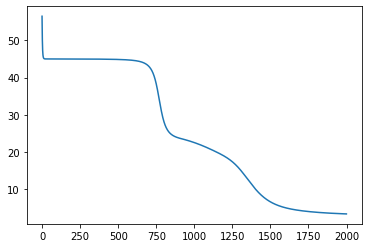

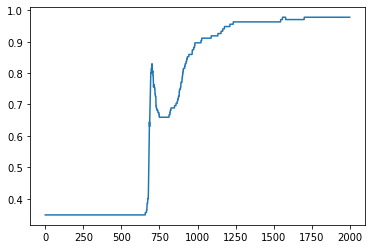

Epoch : 1 Cumulative Error : 45.262855 Accuracy : 0.288889
Epoch : 2 Cumulative Error : 45.191670 Accuracy : 0.288889
Epoch : 3 Cumulative Error : 45.141283 Accuracy : 0.318519
Epoch : 4 Cumulative Error : 45.105386 Accuracy : 0.296296
Epoch : 5 Cumulative Error : 45.079661 Accuracy : 0.296296
Epoch : 6 Cumulative Error : 45.061127 Accuracy : 0.318519
Epoch : 7 Cumulative Error : 45.047710 Accuracy : 0.325926
Epoch : 8 Cumulative Error : 45.037954 Accuracy : 0.348148
Epoch : 9 Cumulative Error : 45.030829 Accuracy : 0.348148
Epoch : 10 Cumulative Error : 45.025606 Accuracy : 0.348148
Epoch : 11 Cumulative Error : 45.021761 Accuracy : 0.348148
Epoch : 12 Cumulative Error : 45.018919 Accuracy : 0.348148
Epoch : 13 Cumulative Error : 45.016810 Accuracy : 0.348148
Epoch : 14 Cumulative Error : 45.015239 Accuracy : 0.348148
Epoch : 15 Cumulative Error : 45.014061 Accuracy : 0.348148
Epoch : 16 Cumulative Error : 45.013174 Accuracy : 0.348148
Epoch : 17 Cumulative Error : 45.012502 Accuracy 

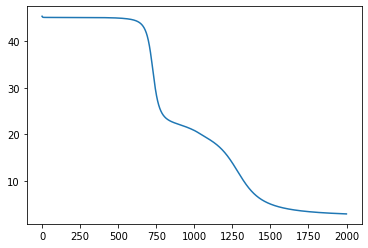

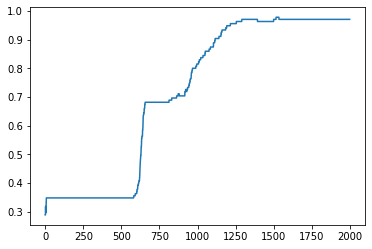

In [9]:
import matplotlib.pyplot as plt

myMLP = MiniBatchGradientMLP([4, 5, 5, 5, 3], 1)
trainTarget = []
for target in irisTrainTargets:
  if target == 0 :
    trainTarget.append([1, 0, 0])
  elif target == 1 :
    trainTarget.append([0, 1, 0])
  elif target == 2 :
    trainTarget.append([0, 0, 1])

trainHistory = myMLP.train(irisTrainInstances, trainTarget, 2000, 0.01, 0.01)
predicted = myMLP.predict(irisTestInstances)
accuracy = 0
for i in range(len(predicted)):
  if predicted[i] == irisTestTargets[i]:
    accuracy += 1
print("Accuracy : ", accuracy/len(irisTestTargets))
print(predicted)
print(irisTestTargets)
plt.plot(trainHistory["CumulativeError"])
plt.show()
plt.plot(trainHistory["Accuracy"])
plt.show()
# myMLP.calcError([0.123, 0.456], [1, 0])

In [10]:
from sklearn import datasets
import pandas as pd

#initialize datasets
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
dataset = df.to_numpy()

#initialize neura; network attribute
input_layer = len(dataset[0]) - 1
hidden_layer = 3
output_layer = len(set([data[-1] for data in dataset]))

#initialize training attribute
learning_rate = 0.1
batch_number = 32
epoch_number = 1000
output_number = output_layer

from sklearn.neural_network import MLPClassifier


classifier = MLPClassifier(hidden_layer_sizes=(hidden_layer,), 
                           max_iter=epoch_number, 
                           activation='logistic', 
                           solver='sgd', 
                           batch_size=batch_number, 
                           learning_rate_init=learning_rate,
                           random_state=1)

classifier.fit(iris.data, iris.target)
prediction_result = classifier.predict(iris.data)

correct = 0
for i in range(len(prediction_result)):
	if (prediction_result[i] == iris.target[i]):
		correct += 1

print('-------RESULT SKLearn-------')        
print('Dataset Size         : ' + str(len(dataset)))
print('Correct Prediction   : ' + str(correct))
print('Accuracy             : ' + str(correct/len(dataset)))

-------RESULT SKLearn-------
Dataset Size         : 150
Correct Prediction   : 142
Accuracy             : 0.9466666666666667
-------RESULT SKLearn-------
Dataset Size         : 150
Correct Prediction   : 142
Accuracy             : 0.9466666666666667


### Pembagian Tugas
#### M. Khairul Makirin - 13517088
1. Layer
2. MiniBatchGradientMLP - feedForward
3. MiniBatchGradientMLP - backwardProp
4. MiniBatchGradientMLP - init

#### Avisenna Abimanyu - 13517010
1. MiniBatchGradientMLP - predict
2. Testing & Debugging
3. Laporan

#### Muhammad Fariz Lutfan Wakan - 13517034
1. MiniBatchGradientMLP - train
2. MiniBatchGradientMLP - calcTotalError
3. Laporan

#### Ihsan Azhar Imaduddin - 13517043
1. MiniBatchGradientMLP - calcTotalError
2. SKLearn MLP
3. Laporan

### Penjelasan Implementasi

Kode diimplemetasikan melalui dua buah kelas, Kelas MiniBatchGradientMLP dan Kelas Layer. Kelas MiniBatchGradientMLP terdiri dari fungsi train yang merupakan fungsi untuk melakukan training pada dataset yang tersedia dengan cara memanggil beberapa fungsi seperti feed forward, backward propagation, dan update weight untuk melakukan pembaharuan terhadap weight dan predict, predict untuk memprediksi target dari sebuah instance, calcErrorTotal untuk menghitung error total setelah mengeksekusi feed forward, fungsi feedForward yang merupakan tahap pertama dalam melakukan training data set untuk mendapatkan out dari output layer, backwardProp untuk mempropagasi error dengan cara memberikan delta weight untuk diubah weight-nya. Kelas Layer yang terdiri dari fungsi activationFunction yang pada kasus ini implementasi dari sigmoid, compute untuk meng-assign input dan output di setiap node pada layer tersebut.